In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import warnings
from statsbombpy.api_client import NoAuthWarning
warnings.simplefilter('ignore', NoAuthWarning)
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

api = StatsBombLoader(getter="remote", creds={"user": "", "passwd": ""})

g = 18240
team_id = 169
df_teams = api.teams(game_id=g)
df_players = api.players(game_id=g)
df_events = api.events(game_id=g)

df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=team_id)
df_actions = (
spadl
.add_names(df_actions)
.merge(api.teams(game_id=g))
.merge(api.players(game_id=g))
)
df_actions = df_actions.sort_values(by=['period_id', 'time_seconds'], ascending=[True, True]).reset_index(drop=True)

In [3]:
df_actions.columns

Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'team_name', 'player_name', 'nickname',
       'jersey_number', 'is_starter', 'starting_position_id',
       'starting_position_name', 'minutes_played'],
      dtype='object')

In [4]:
df_actions.columns

Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'team_name', 'player_name', 'nickname',
       'jersey_number', 'is_starter', 'starting_position_id',
       'starting_position_name', 'minutes_played'],
      dtype='object')

game_id    original_event_id             period_id    time_seconds    team_id
---------  ----------------------------  -----------  --------------  -------------
0m0s       Mario Mandžukić               pass         success         Bayern Munich
0m1s       Thomas Müller                 dribble      success         Bayern Munich
0m1s       Thomas Müller                 pass         success         Bayern Munich
0m2s       Bastian Schweinsteiger        dribble      success         Bayern Munich
0m3s       Bastian Schweinsteiger        pass         success         Bayern Munich
0m4s       Philipp Lahm                  dribble      success         Bayern Munich
0m6s       Philipp Lahm                  pass         success         Bayern Munich
0m8s       Dante Bonfim da Costa Santos  dribble      success         Bayern Munich
0m10s      Dante Bonfim da Costa Santos  pass         success         Bayern Munich
0m11s      David Olatukunbo Alaba        dribble      success         Bayern Munic

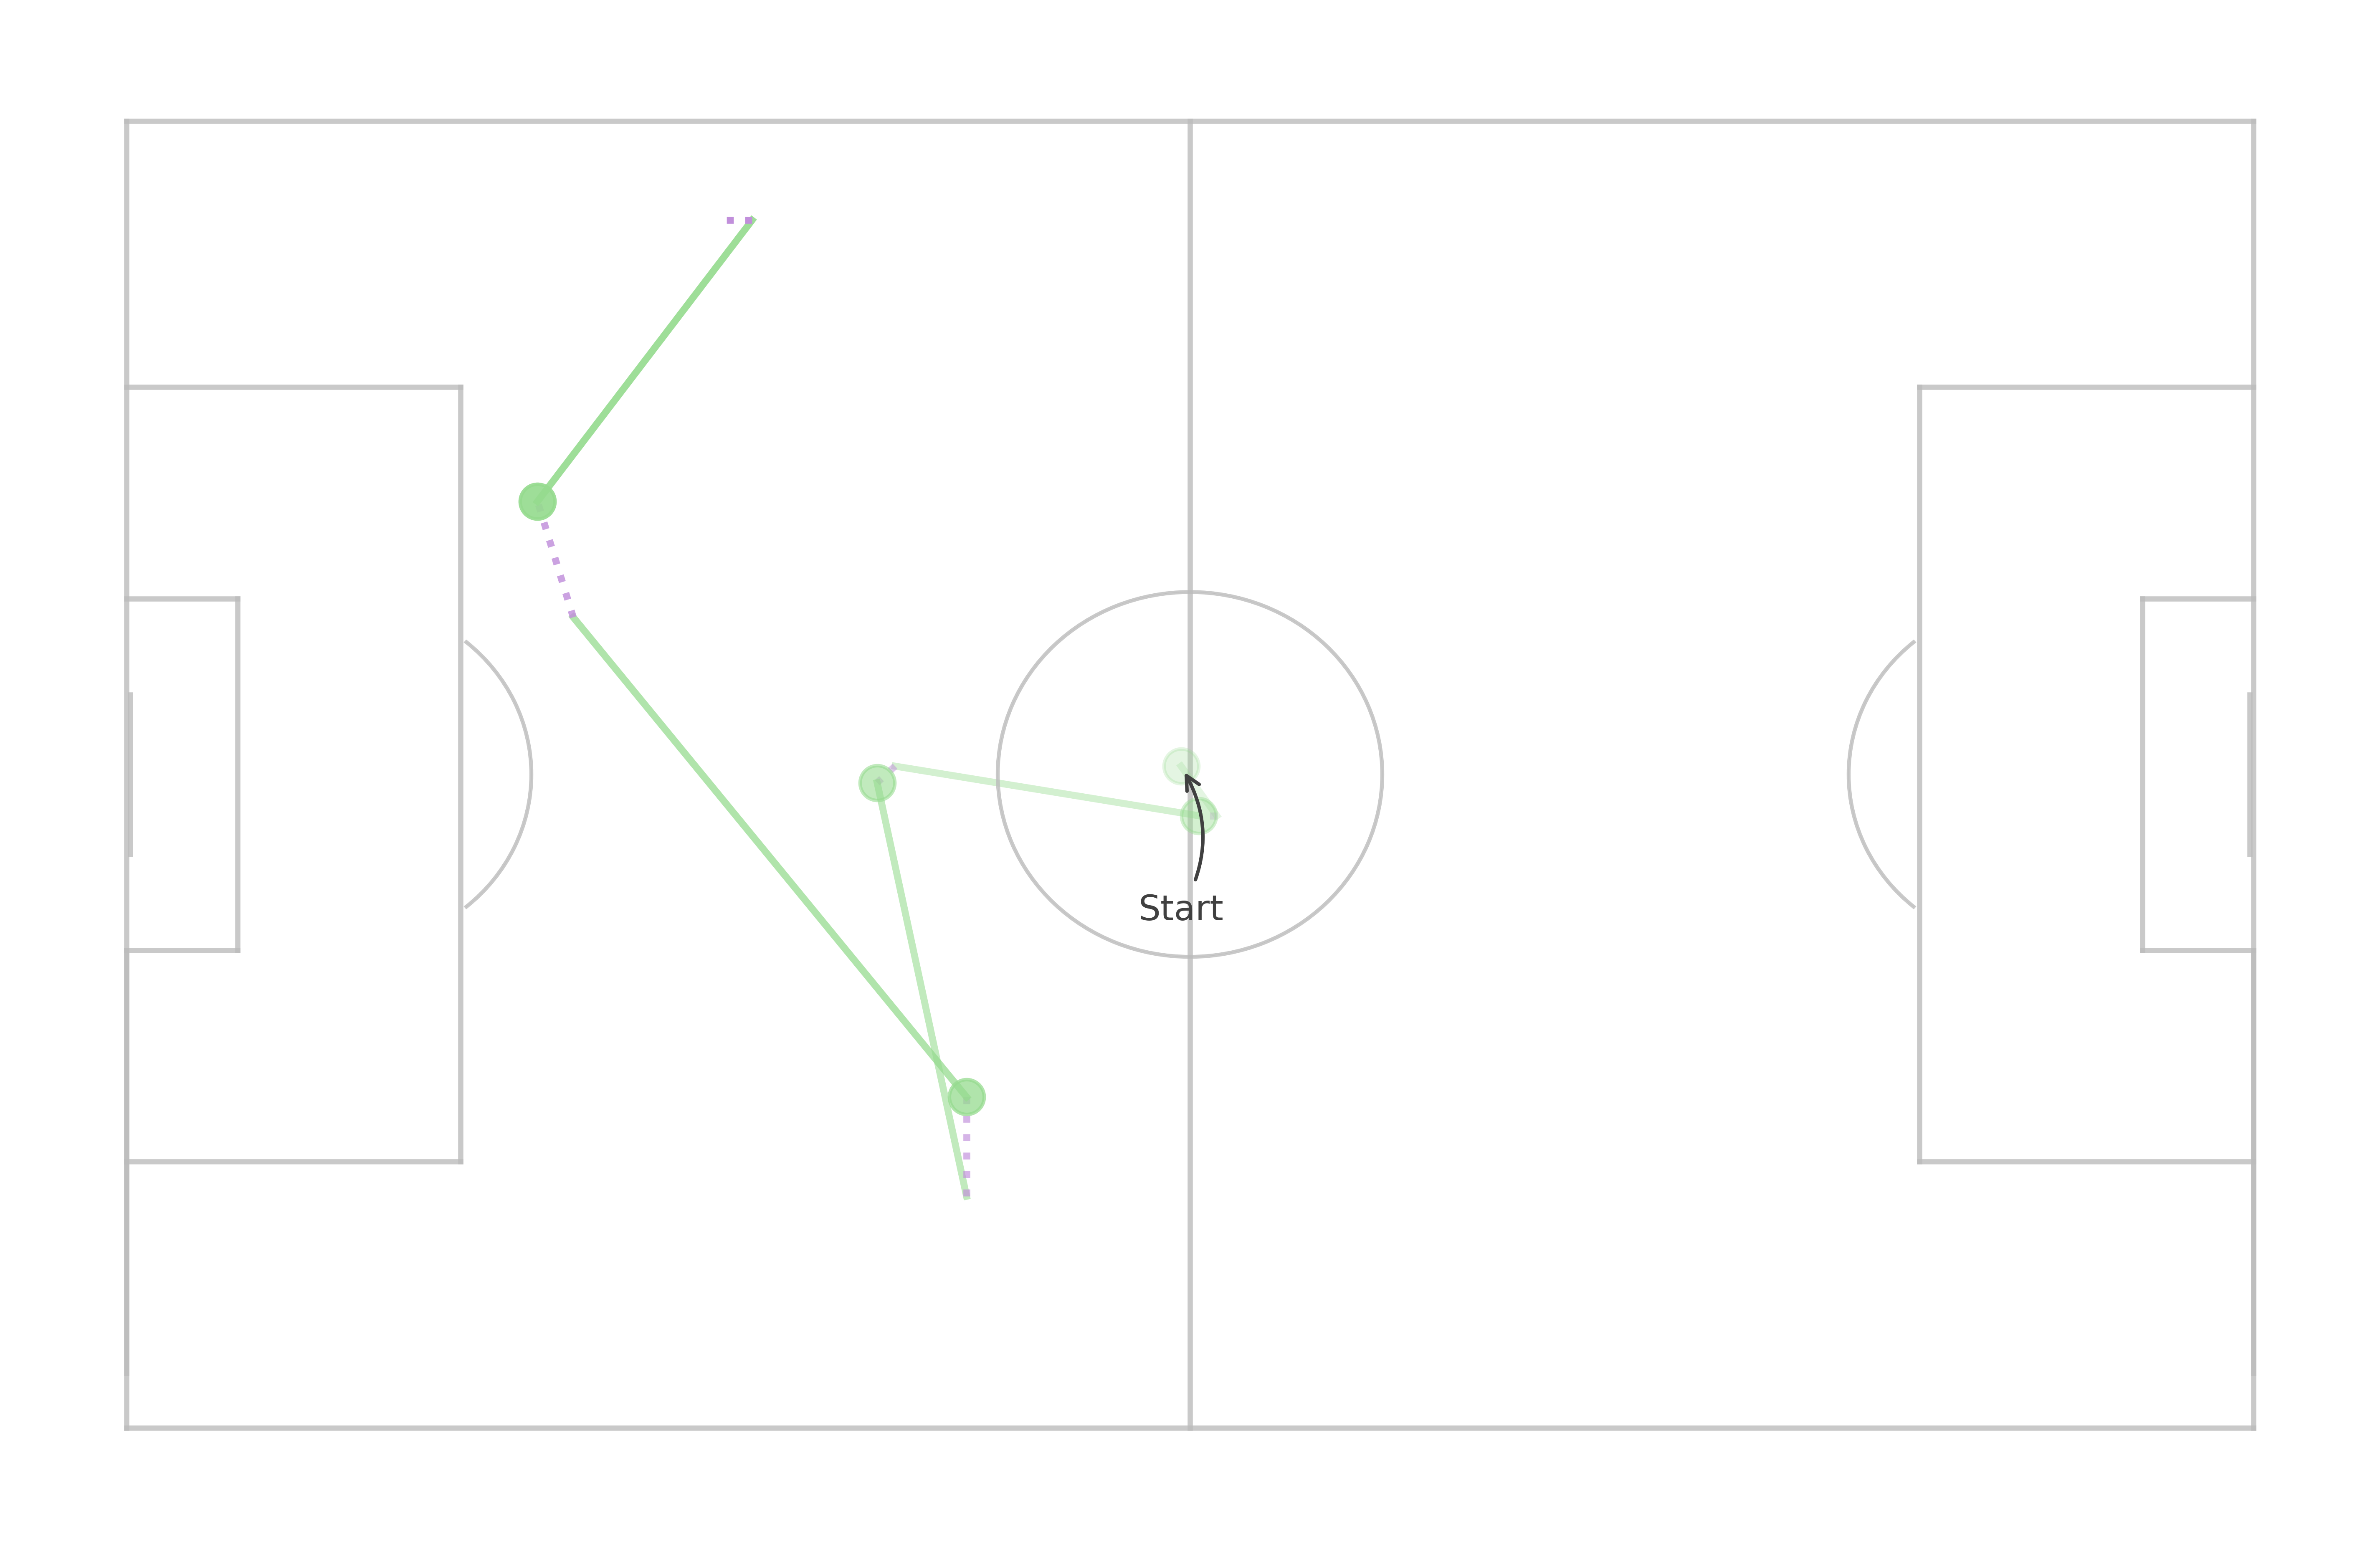

In [8]:
import statsbombplot as pys
from tabulate import tabulate

def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

def find_goal(df):
    df = df[(df['type_id'] == 11) & (df['result_id'] == 1)]
    return df.index

# goals = list(find_goal(df_actions))
# starting_id = goals[0]
starting_id = 9
df = df_actions[starting_id - 9: starting_id + 1].copy()
df = df.reset_index(drop=True)
ax = pys.draw_pitch()

pys.draw_actions(ax, df)

df["nice_time"] = df.apply(nice_time, axis=1)

print(tabulate(df[['nice_time', 'player_name', 'type_name', 'result_name', 'team_name']], headers = df.columns, showindex=False))

In [6]:
df.type_name

0       pass
1    dribble
2       pass
3    dribble
4       pass
5    dribble
6       pass
7    dribble
8      cross
9       shot
Name: type_name, dtype: object

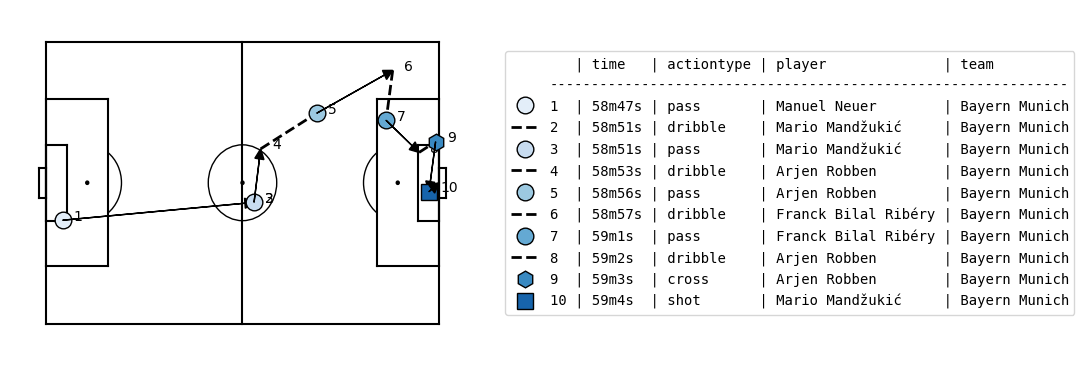

In [7]:
import matplotsoccer

labels = df[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
        location=df[["start_x", "start_y", "end_x", "end_y"]],
        action_type=df.type_name,
        team= df.team_name,
        result= df.result_name == "success",
        label=labels,
        labeltitle=["time", "actiontype", "player", "team"],
        zoom=False,
        figsize=6
    )